# Máquinas de Boltzmann

Hemos estudiado las redes de Hopfield y hemos visto que la capacidad de la red está limitada por los estados espurios.

Usando la regla de aprendizaje vista, la capacidad de una red totalmente conectada es 0.15N patrones (para patrones de distribución aleatoria con $p(+1)=0.5$ con una probabilidad de error de 0.01 ).

Si cada patrón necesita Nbits, entonces la capacidad de la red es $ 0.15 N^2$ bits.

Comparemos la cantidad de información que puede ser guardada en una red de Hopfield en relación a la cantidad de información que necesitamos almacenar para hacer funcionar la red. Es decir, la cantidad de bits necesaria para almacenar los pesos.

La red tiene N^2 valores (entre pesos y bias).

Luego de guardar M patrones, cada conexión tiene un peso acotado entre $[-M, M]$.

Cantidad de bits necesarios: $N^2.log_2(2M+1)$

Para una red de Hopfield que almacena $0.15N^2$ bits, es necesario almacenar $N^2.log_2(2M+1)$ bits de datos.

¿Podemos cambiar la regla de aprendizaje para aumentar la capacidad de la red de Hopfield y así aprovechar al máximo los datos necesarios para guardar los pesos?

Vimos que la capacidad está limitada por el cross-talk term, lo cual hace que se generen patrones espúrios.

Cada vez que memorizamos un patrón, creamos un nuevo mínimo de la función de energía (por lo menos uno).



¿Se puede desaprender un estado espúrio?

¿Podemos dejar corriendo la red desde un estado inicial aleatorio y cuando se estabiliza, restar los $\Delta w_{ij}$ correspondientes a ese patrón? Estaríamos "empujando" para arriba la función de energía para ese punto.

Esta idea es tomada del aporte de Crick-Mitchison, los cuales propusieron que esto es lo que ocurre durante la etapa REM del sueño.

Otra forma de incrementar la capacidad de la red de Hopfield es utilizar una ligera modificación de la regla de aprendizaje del perceptrón, para que los pesos sigan quedando simétricos.

A esta técnica se la conoce como "pseudo-likelihood"

Máquinas de Boltzman:

$w_{ij}=w_{ji} \rightarrow$ se puede definir una función de energía.

Unidades visibles (I/O) y ocultas (solo tienen conexión con las unidades visibles).

Trabajaremos con unidades estocásticas.

La función de energía está dada por:

$$ H\{S_i\}=-\frac{1}{2}\sum_{ij}w_{ij}S_iS_j$$

Denominaremos $\alpha$ a los estados visibles $\rightarrow$ N unidades $\rightarrow 2^N$ estados.  
Denominaremos $\beta$ a los estados ocultos $\rightarrow$ K unidades $\rightarrow 2^K$ estados. Cuando $\beta$ aparezca en algún lugar que no sea un índice nos estaremos a $\beta=\frac{1}{T}$. Es una notación ambigua, pero se utilizará ya que es la misma notación utilizada por el libro.

La probabilidad de encontrar a un sistema en el estado $\{S_i\}$ luego de alcanzado el **equilibrio térmico** es:

$$P\{S_i\}=\frac{e^{-\beta H\{S_i\}}}{Z}$$

donde $Z=\sum_{\{S_i\}}{e^{-\beta H\{S_i\}}}$

La probabilidad de tener un estado visible ($\alpha$) particular es:

$$P_\alpha=\sum_\beta P_{\alpha\beta}=\sum_\beta\frac{e^{-\beta H_{\alpha\beta}}}{Z}$$

donde:

$$H_{\alpha\beta}=-\frac{1}{2}\sum_{ij}{w_{ij}S_i^{\alpha\beta}S_j^{\alpha\beta}}$$

$H_{\alpha\beta}$ es la energía del estado $S_i=S_i^{\alpha\beta}$.

Definamos a $R_\alpha$ como la probabilidad deseada para el estado $\alpha$.

Una estrategia posible es utilizar la entropía relativa:

$E=\sum_\alpha R_\alpha log \frac{R_\alpha}{P_\alpha}$

* E mide diferencia entre distribuciones de probabilidad
* No es una distancia, ya que es asimétrica
* Es positiva, o cero
* Si es cero, $R_\alpha=P_\alpha \forall  \alpha$

Podemos aplicar gradient descent para encontrar los pesos que minimizan la entropía relativa:

$$\Delta w_{ij}=-\eta \frac{\partial E}{\partial w_{ij}} $$

Si desarrollamos las ecuaciones se llega a:

$$\Delta w_{ij}=\eta \beta [\overline{<S_iS_j>}_{clamped} - <S_iS_j>_{free}] $$

Los valores de $\overline{<S_iS_j>}_{clamped}$ y $<S_iS_j>_{free}$ se pueden estimar utilizando el método de Montecarlo seleccionando unidades al azar y actualizándolas según la regla:

$$Prob(S_i \rightarrow -S_i)=\frac{1}{1+e^{\beta\Delta H_i}}$$

Para lograr el **equilibrio térmico** a muy baja temperatura la cantidad de iteraciones es muy alta. Por eso se utiliza un procedimiento denominado **Simulated annealing**. El mismo consiste en comenzar a utilizar la red a una temperatura alta e ir bajando la temperatura hasta llegar a T=1.

Aún utilizando simulated annealing, el entrenamiento es muy lento. Y utilizar un sistema poco equilibrado o pocas muestras para estimar las medias, hace que los $w_{ij}$ contengan errores, y por lo tante lleve mas iteraciones converger a una solución.

Otra opción es actualizar varias unidades a la vez tomadas de a una cantidad aleatoria. Hay que tener cuidado porque aumentan las **oscilaciones bifase** (las cuales ocurren en actualización sincrónica).

Hay un caso particular de las máquinas de Boltzmann, que es cuando las unidades visibles no están conectadas entre sí, ni las unidades ocultas están conectadas entre sí. Es decir, la red es un grafo biparticionado entre las unidades visibles y las unidades ocultas.

<img src="rbm.png">



In [30]:
def signo_vec(vec):
    vec[vec >0]=1
    vec[vec <=0]=-1
    return vec

p1=np.array([1,1,1,1,-1,-1,1,1,1,1],dtype='float64')
p2=np.array([1,1,-1,-1,-1,-1,1,-1,-1,1],dtype='float64')
p3=np.array([1,-1,1,-1,1,-1,1,-1,-1,1],dtype='float64')
p4=signo_vec(p1+p2+p3)
p1=p1/2+0.5
p2=p2/2+0.5
p3=p3/2+0.5
p4=p4/2+0.5

from __future__ import print_function
import numpy as np

class RBM:
  
    def __init__(self, num_visible, num_hidden, learning_rate = 0.1):
        self.num_hidden = num_hidden
        self.num_visible = num_visible
        self.learning_rate = learning_rate

        # Initialize a weight matrix, of dimensions (num_visible x num_hidden), using
        # a Gaussian distribution with mean 0 and standard deviation 0.1.
        self.weights = 0.1 * np.random.randn(self.num_visible, self.num_hidden)    
        # Insert weights for the bias units into the first row and first column.
        self.weights = np.insert(self.weights, 0, 0, axis = 0)
        self.weights = np.insert(self.weights, 0, 0, axis = 1)

    def train(self, data, max_epochs = 1000):
        """
            Train the machine.
            Parameters
            ----------
            data: A matrix where each row is a training example consisting of the states of visible units.    
        """

        num_examples = data.shape[0]

        # Insert bias units of 1 into the first column.
        data = np.insert(data, 0, 1, axis = 1)

        for epoch in range(max_epochs):      
          # Clamp to the data and sample from the hidden units. 
          # (This is the "positive CD phase", aka the reality phase.)
            pos_hidden_activations = np.dot(data, self.weights)      
            pos_hidden_probs = self._logistic(pos_hidden_activations)
            pos_hidden_states = pos_hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
            # Note that we're using the activation *probabilities* of the hidden states, not the hidden states       
            # themselves, when computing associations. We could also use the states; see section 3 of Hinton's 
            # "A Practical Guide to Training Restricted Boltzmann Machines" for more.
            pos_associations = np.dot(data.T, pos_hidden_probs)

            # Reconstruct the visible units and sample again from the hidden units.
            # (This is the "negative CD phase", aka the daydreaming phase.)
            neg_visible_activations = np.dot(pos_hidden_states, self.weights.T)
            neg_visible_probs = self._logistic(neg_visible_activations)
            neg_visible_probs[:,0] = 1 # Fix the bias unit.
            neg_hidden_activations = np.dot(neg_visible_probs, self.weights)
            neg_hidden_probs = self._logistic(neg_hidden_activations)
            # Note, again, that we're using the activation *probabilities* when computing associations, not the states 
            # themselves.
            neg_associations = np.dot(neg_visible_probs.T, neg_hidden_probs)

            # Update weights.
            self.weights += self.learning_rate * ((pos_associations - neg_associations) / num_examples)

            error = np.sum((data - neg_visible_probs) ** 2)
            print("Epoch %s: error is %s" % (epoch, error))

    def run_visible(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of visible units, to get a sample of the hidden units.

        Parameters
        ----------
        data: A matrix where each row consists of the states of the visible units.

        Returns
        -------
        hidden_states: A matrix where each row consists of the hidden units activated from the visible
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the hidden units (plus a bias unit)
        # sampled from a training example.
        hidden_states = np.ones((num_examples, self.num_hidden + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the hidden units.
        hidden_activations = np.dot(data, self.weights)
        # Calculate the probabilities of turning the hidden units on.
        hidden_probs = self._logistic(hidden_activations)
        # Turn the hidden units on with their specified probabilities.
        hidden_states[:,:] = hidden_probs > np.random.rand(num_examples, self.num_hidden + 1)
        # Always fix the bias unit to 1.
        # hidden_states[:,0] = 1

        # Ignore the bias units.
        hidden_states = hidden_states[:,1:]
        return hidden_states
    
  # TODO: Remove the code duplication between this method and `run_visible`?
    def run_hidden(self, data):
        """
        Assuming the RBM has been trained (so that weights for the network have been learned),
        run the network on a set of hidden units, to get a sample of the visible units.
        Parameters
        ----------
        data: A matrix where each row consists of the states of the hidden units.
        Returns
        -------
        visible_states: A matrix where each row consists of the visible units activated from the hidden
        units in the data matrix passed in.
        """

        num_examples = data.shape[0]

        # Create a matrix, where each row is to be the visible units (plus a bias unit)
        # sampled from a training example.
        visible_states = np.ones((num_examples, self.num_visible + 1))

        # Insert bias units of 1 into the first column of data.
        data = np.insert(data, 0, 1, axis = 1)

        # Calculate the activations of the visible units.
        visible_activations = np.dot(data, self.weights.T)
        # Calculate the probabilities of turning the visible units on.
        visible_probs = self._logistic(visible_activations)
        # Turn the visible units on with their specified probabilities.
        visible_states[:,:] = visible_probs > np.random.rand(num_examples, self.num_visible + 1)
        # Always fix the bias unit to 1.
        # visible_states[:,0] = 1

        # Ignore the bias units.
        visible_states = visible_states[:,1:]
        return visible_states
    
    def daydream(self, num_samples):
        """
        Randomly initialize the visible units once, and start running alternating Gibbs sampling steps
        (where each step consists of updating all the hidden units, and then updating all of the visible units),
        taking a sample of the visible units at each step.
        Note that we only initialize the network *once*, so these samples are correlated.
        Returns
        -------
        samples: A matrix, where each row is a sample of the visible units produced while the network was
        daydreaming.
        """

        # Create a matrix, where each row is to be a sample of of the visible units 
        # (with an extra bias unit), initialized to all ones.
        samples = np.ones((num_samples, self.num_visible + 1))

        # Take the first sample from a uniform distribution.
        samples[0,1:] = np.random.rand(self.num_visible)

        # Start the alternating Gibbs sampling.
        # Note that we keep the hidden units binary states, but leave the
        # visible units as real probabilities. See section 3 of Hinton's
        # "A Practical Guide to Training Restricted Boltzmann Machines"
        # for more on why.
        for i in range(1, num_samples):
            visible = samples[i-1,:]

            # Calculate the activations of the hidden units.
            hidden_activations = np.dot(visible, self.weights)      
            # Calculate the probabilities of turning the hidden units on.
            hidden_probs = self._logistic(hidden_activations)
            # Turn the hidden units on with their specified probabilities.
            hidden_states = hidden_probs > np.random.rand(self.num_hidden + 1)
            # Always fix the bias unit to 1.
            hidden_states[0] = 1

            # Recalculate the probabilities that the visible units are on.
            visible_activations = np.dot(hidden_states, self.weights.T)
            visible_probs = self._logistic(visible_activations)
            visible_states = visible_probs > np.random.rand(self.num_visible + 1)
            samples[i,:] = visible_states

    # Ignore the bias units (the first column), since they're always set to 1.
        return samples[:,1:]        
      
    def _logistic(self, x):
        return 1.0 / (1 + np.exp(-x))

r = RBM(num_visible =10, num_hidden = 3)
training_data = np.array([p1,p2,p3])
#training_data = np.array([[1,1,1,0,0,0],[1,0,1,0,0,0],[1,1,1,0,0,0],[0,0,1,1,1,0], [0,0,1,1,0,0],[0,0,1,1,1,0]])
r.train(training_data, max_epochs = 5000)
print(r.weights)
user = np.array([p4])
print("Probaremos con el vector:")
print(p4)
for i in range(1,10):    
    hid_states=r.run_visible(user)
    print(hid_states)
    vis_states=r.run_hidden(hid_states)
    print(vis_states)


Epoch 0: error is 7.53225368979
Epoch 1: error is 7.37911870651
Epoch 2: error is 7.25806267447
Epoch 3: error is 6.90220476677
Epoch 4: error is 6.61977509592
Epoch 5: error is 6.47620164886
Epoch 6: error is 5.95510422902
Epoch 7: error is 5.85284803756
Epoch 8: error is 5.50597583151
Epoch 9: error is 5.833610813
Epoch 10: error is 5.70315107544
Epoch 11: error is 5.89882184632
Epoch 12: error is 5.36242234375
Epoch 13: error is 4.66336725223
Epoch 14: error is 4.67790200382
Epoch 15: error is 5.77485032653
Epoch 16: error is 4.52822783752
Epoch 17: error is 4.62594298552
Epoch 18: error is 4.30728638963
Epoch 19: error is 4.3367910374
Epoch 20: error is 4.40343054534
Epoch 21: error is 4.41212143565
Epoch 22: error is 4.18528484776
Epoch 23: error is 4.1991005858
Epoch 24: error is 4.15642078878
Epoch 25: error is 4.40153855324
Epoch 26: error is 4.12821296191
Epoch 27: error is 4.08301477912
Epoch 28: error is 4.21443232659
Epoch 29: error is 4.33035094488
Epoch 30: error is 4.258

Epoch 1121: error is 1.61531090527
Epoch 1122: error is 1.61485715089
Epoch 1123: error is 1.61440739472
Epoch 1124: error is 1.61396151146
Epoch 1125: error is 1.61351938376
Epoch 1126: error is 1.61308090163
Epoch 1127: error is 1.61264596185
Epoch 1128: error is 1.61221446741
Epoch 1129: error is 1.61178632708
Epoch 1130: error is 1.61136145495
Epoch 1131: error is 1.61093977
Epoch 1132: error is 1.6105211958
Epoch 1133: error is 1.6101056601
Epoch 1134: error is 1.60969309459
Epoch 1135: error is 1.60928343458
Epoch 1136: error is 1.60887661876
Epoch 1137: error is 1.60847258895
Epoch 1138: error is 1.60807128987
Epoch 1139: error is 1.607672669
Epoch 1140: error is 1.6072766763
Epoch 1141: error is 1.60688326413
Epoch 1142: error is 1.60649238705
Epoch 1143: error is 1.60610400165
Epoch 1144: error is 1.60571806648
Epoch 1145: error is 1.60533454187
Epoch 1146: error is 1.31845409418
Epoch 1147: error is 1.60658966437
Epoch 1148: error is 1.60604169578
Epoch 1149: error is 1.60551

Epoch 2107: error is 1.52805249881
Epoch 2108: error is 1.52699489291
Epoch 2109: error is 1.52605182074
Epoch 2110: error is 1.5252098841
Epoch 2111: error is 1.52445728721
Epoch 2112: error is 1.52378364858
Epoch 2113: error is 1.52317983357
Epoch 2114: error is 1.52263780559
Epoch 2115: error is 1.52215049436
Epoch 2116: error is 1.52171167938
Epoch 2117: error is 1.52131588712
Epoch 2118: error is 1.52095830031
Epoch 2119: error is 1.52063467821
Epoch 2120: error is 1.11281950716
Epoch 2121: error is 1.5234713536
Epoch 2122: error is 1.52288078975
Epoch 2123: error is 1.52235083527
Epoch 2124: error is 1.52187458837
Epoch 2125: error is 1.5214459769
Epoch 2126: error is 1.52105965797
Epoch 2127: error is 1.52071092961
Epoch 2128: error is 1.52039565296
Epoch 2129: error is 1.52011018384
Epoch 2130: error is 1.51985131267
Epoch 2131: error is 1.10610111469
Epoch 2132: error is 1.52266133215
Epoch 2133: error is 1.52214162095
Epoch 2134: error is 1.52167500281
Epoch 2135: error is 1.

Epoch 3221: error is 0.0454539024892
Epoch 3222: error is 0.045386161901
Epoch 3223: error is 0.0453186639438
Epoch 3224: error is 0.0452514047802
Epoch 3225: error is 0.0451843806977
Epoch 3226: error is 0.0451175881041
Epoch 3227: error is 0.0450510235224
Epoch 3228: error is 0.0449846835864
Epoch 3229: error is 0.0449185650364
Epoch 3230: error is 0.044852664715
Epoch 3231: error is 0.0447869795631
Epoch 3232: error is 0.0447215066165
Epoch 3233: error is 0.0446562430017
Epoch 3234: error is 0.0445911859328
Epoch 3235: error is 0.0445263327081
Epoch 3236: error is 0.044461680707
Epoch 3237: error is 0.0443972273869
Epoch 3238: error is 0.0443329702802
Epoch 3239: error is 0.0442689069917
Epoch 3240: error is 0.0442050351959
Epoch 3241: error is 0.0441413526343
Epoch 3242: error is 0.044077857113
Epoch 3243: error is 0.0440145465007
Epoch 3244: error is 0.0439514187257
Epoch 3245: error is 0.0438884717746
Epoch 3246: error is 0.0438257036895
Epoch 3247: error is 0.0437631125666
Epoch

Epoch 4348: error is 0.0144241639855
Epoch 4349: error is 0.014412080424
Epoch 4350: error is 0.0144000144498
Epoch 4351: error is 0.014387966016
Epoch 4352: error is 0.0143759350762
Epoch 4353: error is 0.0143639215839
Epoch 4354: error is 0.0143519254931
Epoch 4355: error is 0.0143399467579
Epoch 4356: error is 0.0143279853323
Epoch 4357: error is 0.014316041171
Epoch 4358: error is 0.0143041142284
Epoch 4359: error is 0.0142922044594
Epoch 4360: error is 0.0142803118191
Epoch 4361: error is 0.0142684362625
Epoch 4362: error is 0.0142565777451
Epoch 4363: error is 0.0142447362224
Epoch 4364: error is 0.0142329116502
Epoch 4365: error is 0.0142211039844
Epoch 4366: error is 0.0142093131811
Epoch 4367: error is 0.0141975391967
Epoch 4368: error is 0.0141857819876
Epoch 4369: error is 0.0141740415105
Epoch 4370: error is 0.0141623177223
Epoch 4371: error is 0.0141506105799
Epoch 4372: error is 0.0141389200407
Epoch 4373: error is 0.0141272460619
Epoch 4374: error is 0.0141155886013
Epoc

## Detección de dígitos utilizando RBM

In [95]:
from __future__ import print_function
from mnist import MNIST
import numpy as np
mndata = MNIST('./dir_with_mnist_data_files')
test_img, test_label = mndata.load_testing()
train_img, train_label = mndata.load_training()

# Authors: Yann N. Dauphin, Vlad Niculae, Gabriel Synnaeve
# License: BSD

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline


# #############################################################################
# Setting up

def nudge_dataset(X, Y):
    """
    This produces a dataset 5 times bigger than the original one,
    by moving the 8x8 images in X around by 1px to left, right, down, up
    """
    direction_vectors = [
        [[0, 1, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [1, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 1],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 1, 0]]]

    shift = lambda x, w: convolve(x.reshape((8, 8)), mode='constant',
                                  weights=w).ravel()
    X = np.concatenate([X] +
                       [np.apply_along_axis(shift, 1, X, vector)
                        for vector in direction_vectors])
    Y = np.concatenate([Y for _ in range(5)], axis=0)
    return X, Y

# Load Data
#igits = datasets.load_digits()
digits = datasets.load_digits()
# = np.asarray(digits.data, 'float32')
#, Y = nudge_dataset(X, digits.target)
#, Y = nudge_dataset(train_img,train_label)
train_img = (train_img - np.min(train_img, 0)) / (np.max(train_img, 0) + 0.0001)  # 0-1 scaling

#Xtrain, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    #est_size=0.2,
                                                    #andom_state=0)
X_train=train_img
Y_train=train_label
X_test=test_img
Y_test=test_label
# Models we will use
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)

classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

# #############################################################################
# Training

# Hyper-parameters. These were set by cross-validation,
# using a GridSearchCV. Here we are not performing cross-validation to
# save time.
rbm.learning_rate = 0.005
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 30*30
logistic.C = 6000.0
print("Entrenando el modelo RBM-Logistic")
# Training RBM-Logistic Pipeline
classifier.fit(X_train, Y_train)

print("Entrenando el modelo Logistic Regression")
# Training Logistic regression
#logistic_classifier = linear_model.LogisticRegression(C=100.0)
#logistic_classifier.fit(X_train, Y_train)

# #############################################################################
# Evaluation

print()
print("Logistic regression using RBM features:\n%s\n" % (
    metrics.classification_report(
        np.array(Y_test),
        classifier.predict(X_test))))

#print("Logistic regression using raw pixel features:\n%s\n" % (
#    metrics.classification_report(
#        Y_test,
#        logistic_classifier.predict(X_test))))


Entrenando el modelo RBM-Logistic
[BernoulliRBM] Iteration 1, pseudo-likelihood = -96.74, time = 66.95s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -84.48, time = 73.31s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -77.10, time = 74.66s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -71.85, time = 73.06s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -70.36, time = 74.19s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -69.91, time = 74.17s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -66.83, time = 73.90s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -65.89, time = 76.83s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -65.10, time = 77.81s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -63.19, time = 74.41s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -62.87, time = 75.25s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -62.25, time = 75.21s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -62.37, time = 75.35s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -61

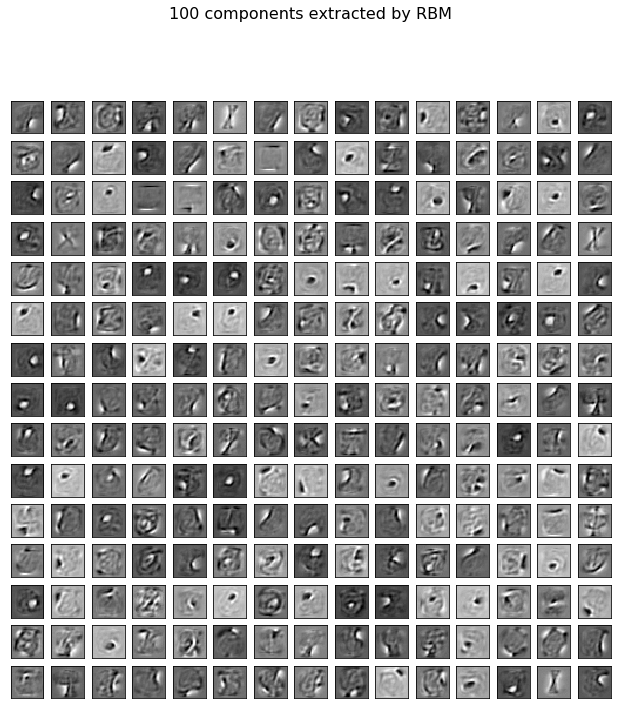

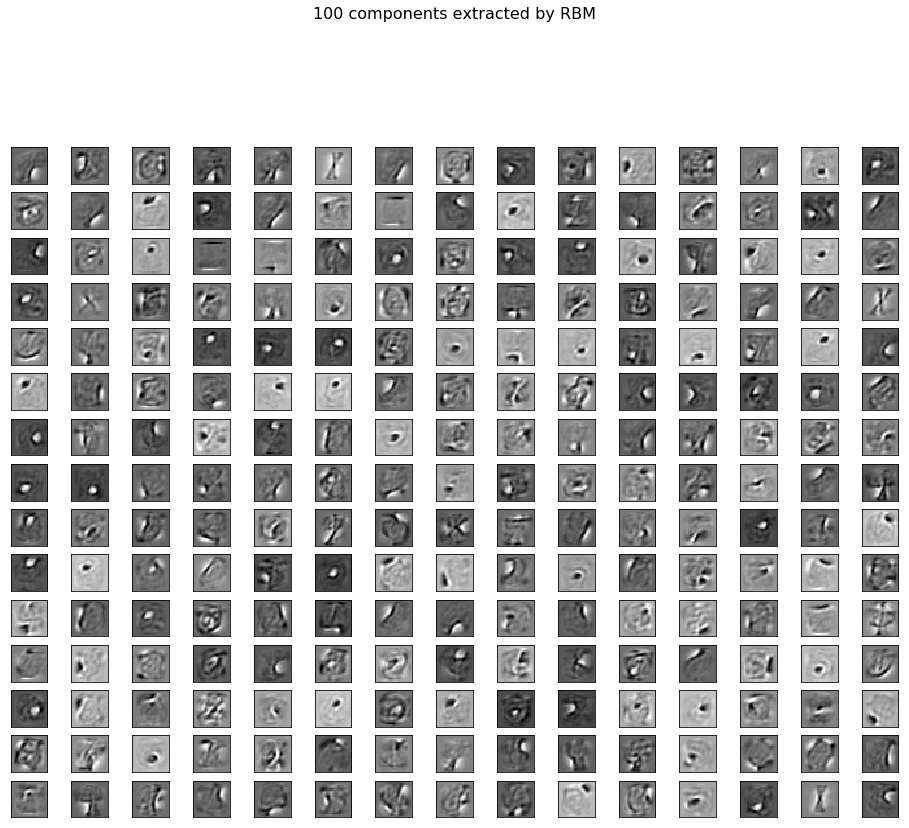

In [70]:
# #############################################################################
# Plotting

plt.figure(figsize=(10, 10))
for i, comp in enumerate(rbm.components_):
    plt.subplot(30, 30, i + 1)
    plt.imshow(comp.reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('100 components extracted by RBM', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

plt.show()

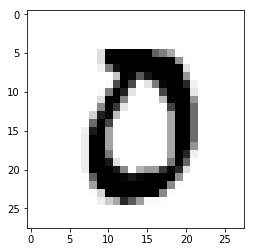

In [93]:
plt.imshow(np.array(test_img[28]).reshape((28, 28)), cmap=plt.cm.gray_r,
               interpolation='nearest')
plt.show()

# Optimización de hiperparámetros utilizando [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)